In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,40766,41078,41498,41957,42432,42840,43256,43664,43945,44299
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2040,2041,2041,2041,2047,2049,2050,2051,2051,2052
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14830,14974,15052,15089,15170,15224,15301,15339,15415,15458


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-5.124940e+03,0.000000e+00,1.069880e+05,-5.124940e+03,-5.124940e+03,19198.260253,19198.260253,19198.260253,19198.260253,19198.260253,19198.260253,0.0,0.0,0.0,1.407332e+04
3,2020-01-25,-2.189963e+03,0.000000e+00,1.216692e+05,-2.189963e+03,-2.189963e+03,22372.494917,22372.494917,22372.494917,22372.494917,22372.494917,22372.494917,0.0,0.0,0.0,2.018253e+04
4,2020-01-26,7.450136e+02,0.000000e+00,9.771450e+04,7.450136e+02,7.450136e+02,4701.269266,4701.269266,4701.269266,4701.269266,4701.269266,4701.269266,0.0,0.0,0.0,5.446283e+03
8,2020-01-30,1.248492e+04,0.000000e+00,1.091333e+05,1.248492e+04,1.248492e+04,4240.353930,4240.353930,4240.353930,4240.353930,4240.353930,4240.353930,0.0,0.0,0.0,1.672527e+04
9,2020-01-31,1.541990e+04,0.000000e+00,1.288669e+05,1.541990e+04,1.541990e+04,19198.260253,19198.260253,19198.260253,19198.260253,19198.260253,19198.260253,0.0,0.0,0.0,3.461816e+04
10,2020-02-01,1.835487e+04,0.000000e+00,1.324570e+05,1.835487e+04,1.835487e+04,22372.494917,22372.494917,22372.494917,22372.494917,22372.494917,22372.494917,0.0,0.0,0.0,4.072737e+04
11,2020-02-02,2.128985e+04,0.000000e+00,1.240984e+05,2.128985e+04,2.128985e+04,4701.269266,4701.269266,4701.269266,4701.269266,4701.269266,4701.269266,0.0,0.0,0.0,2.599112e+04
12,2020-02-03,2.422483e+04,0.000000e+00,9.428069e+04,2.422483e+04,2.422483e+04,-19219.581962,-19219.581962,-19219.581962,-19219.581962,-19219.581962,-19219.581962,0.0,0.0,0.0,5.005246e+03
13,2020-02-04,2.715981e+04,0.000000e+00,9.898595e+04,2.715981e+04,2.715981e+04,-21221.846451,-21221.846451,-21221.846451,-21221.846451,-21221.846451,-21221.846451,0.0,0.0,0.0,5.937959e+03
14,2020-02-05,3.009478e+04,0.000000e+00,1.190760e+05,3.009478e+04,3.009478e+04,-10070.949953,-10070.949953,-10070.949953,-10070.949953,-10070.949953,-10070.949953,0.0,0.0,0.0,2.002383e+04


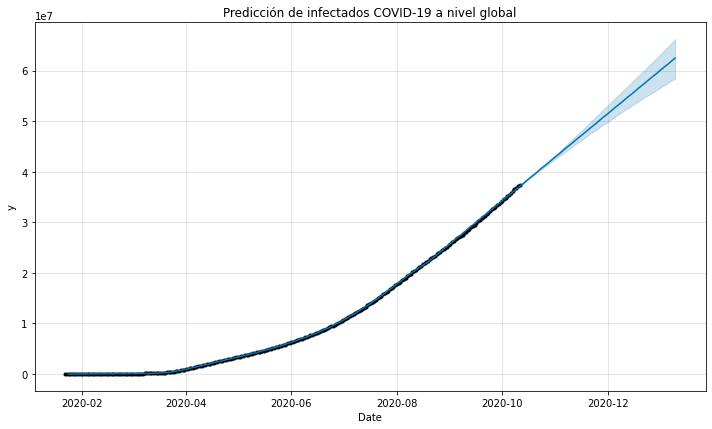

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,40766,41078,41498,41957,42432,42840,43256,43664,43945,44299
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2040,2041,2041,2041,2047,2049,2050,2051,2051,2052
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,14830,14974,15052,15089,15170,15224,15301,15339,15415,15458


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,96
1,Albania,168
2,Algeria,132
3,Andorra,0
4,Angola,120
...,...,...
261,West Bank and Gaza,354
262,Western Sahara,0
263,Yemen,1
264,Zambia,43


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
23,Belgium,5327,11589616,459.635591
177,Netherlands,6373,17134873,371.931557
168,Montenegro,228,628062,363.021485
184,Oman,1761,5106622,344.846358
92,Czechia,3105,10708982,289.943526
33,Cabo Verde,159,555988,285.977395
24,Belize,104,397621,261.555602
7,Armenia,715,2963234,241.290428
6,Argentina,10324,45195777,228.428422
162,Malta,95,441539,215.156532


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



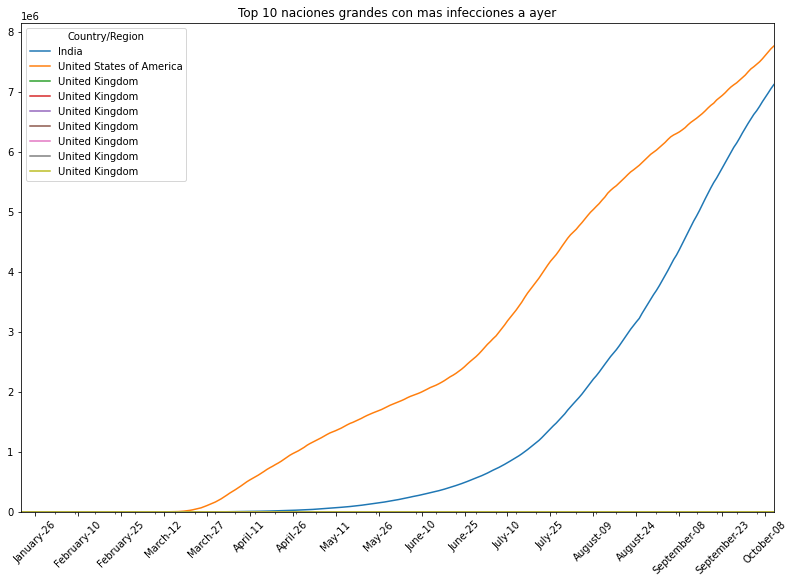

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,96,38928341,2.466070
1,Albania,168,2877800,58.377928
2,Algeria,132,43851043,3.010191
3,Andorra,0,77265,0.000000
4,Angola,120,32866267,3.651160
...,...,...,...,...
241,Uzbekistan,322,33469199,9.620786
242,Western Sahara,0,597330,0.000000
243,Yemen,1,29825967,0.033528
244,Zambia,43,18383956,2.338996


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")